In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D, MaxPooling2D, Activation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import time

In [2]:
cifar100 = tf.keras.datasets.cifar100
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

In [ ]:
start_time = time.time()

In [ ]:
# Normalizing the train and test
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255
test_images = test_images / 255

### Task1 : Creation of Baseline Model

In [ ]:
# Created the baseline model
def create_baseline_model():
  tf.compat.v1.reset_default_graph()
  baseline_model = Sequential()
  baseline_model.add(layers.Conv2D(16, (7, 7), activation='relu', input_shape=(32, 32, 3), strides=1))
  baseline_model.add(layers.MaxPooling2D(pool_size=2, strides=2))
  baseline_model.add(layers.Conv2D(32, (5, 5), activation='relu', strides=1))
  baseline_model.add(layers.MaxPooling2D(pool_size=2, strides=2))
  baseline_model.add(layers.Flatten())
  baseline_model.add(layers.Dense(128, activation='relu'))
  baseline_model.add(layers.Dense(100))

  return baseline_model

In [ ]:
baseline_model = create_baseline_model()

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 32)          12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               6

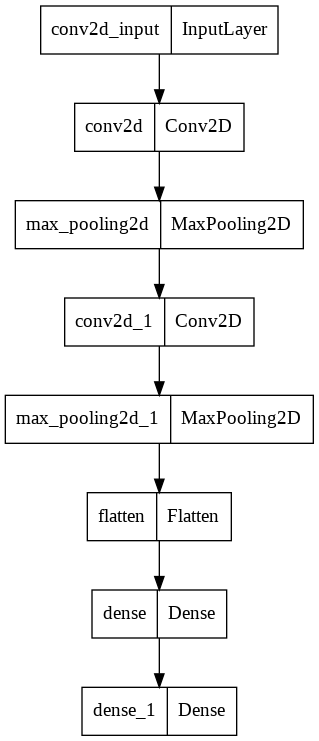

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
baseline_model , to_file='baseline_model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
def baseline_model_train(baseline_model, train_images, train_labels):
  batch_size = 32
  validation_split = 0.25
  verbosity = 1
  no_epochs = 30
  initial_learning_rate = 0.001

  #Early stopping the runs incase the validation loss does not improve
  earlystopper = EarlyStopping(monitor='val_loss', mode='min',
                               verbose=1, patience=7)
  #Checkpointing the model to local storage on the basis of validation accuracy
  modelcheckpointer = ModelCheckpoint('best_model_baseline.h5',
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1, save_best_only=True)
  # Reducing learning rate on the basis of valiation loss
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=4, min_lr=0.0001)

  baseline_model.compile(
      optimizer = tf.keras.optimizers.Adamax(learning_rate=initial_learning_rate),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[ tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),],)

  history = baseline_model.fit(train_images, train_labels,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              validation_split=validation_split, callbacks=[modelcheckpointer, reduce_lr, earlystopper])
  
  #Load the model and evaluate it
  saved_model = load_model('best_model_baseline.h5')
  _, test_accuracy = saved_model.evaluate(test_images,  test_labels, verbose=1)
  print('Accuracy on test data : %.2f' % (test_accuracy))

  return history

In [ ]:
train_hist_baseline = baseline_model_train(baseline_model, train_images, train_labels)

Epoch 1/30
1172/1172 [==============================] - ETA: 0s - loss: 4.1952 - accuracy: 0.0640
Epoch 1: val_accuracy improved from -inf to 0.11032, saving model to best_model_baseline.h5
1172/1172 [==============================] - 6s 5ms/step - loss: 4.1952 - accuracy: 0.0640 - val_loss: 3.9378 - val_accuracy: 0.1103 - lr: 0.0010
Epoch 2/30
1172/1172 [==============================] - ETA: 0s - loss: 3.7733 - accuracy: 0.1334
Epoch 2: val_accuracy improved from 0.11032 to 0.15336, saving model to best_model_baseline.h5
1172/1172 [==============================] - 5s 5ms/step - loss: 3.7733 - accuracy: 0.1334 - val_loss: 3.6718 - val_accuracy: 0.1534 - lr: 0.0010
Epoch 3/30
1166/1172 [============================>.] - ETA: 0s - loss: 3.5619 - accuracy: 0.1690
Epoch 3: val_accuracy improved from 0.15336 to 0.17296, saving model to best_model_baseline.h5
1172/1172 [==============================] - 5s 4ms/step - loss: 3.5617 - accuracy: 0.1689 - val_loss: 3.5253 - val_accuracy: 0.1730

In [3]:
# Method to plot the accuracy over training set and validation set
def create_accuracy_plot(model_hist):
    plt.plot(model_hist.history["accuracy"])
    plt.plot(model_hist.history["val_accuracy"])
    plt.title("model performance")
    plt.ylabel("accuracy score")
    plt.xlabel("num_epoch")
    plt.legend(["train_set", "validation_set"], loc="upper left")
    plt.show()

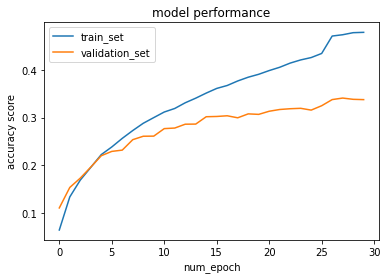

In [ ]:
create_accuracy_plot(train_hist_baseline)

### Task 2: Improve Baseline Model Performance

In [ ]:
# Function to improve the baseline model
def create_improved_model():
  
  tf.compat.v1.reset_default_graph()
  improved_model = Sequential()
  improved_model.add(Conv2D(32, kernel_size=(3, 3), activation=LeakyReLU(0.1), input_shape=(32, 32, 3)))
  improved_model.add(tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.003))
  improved_model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation=LeakyReLU(0.1)))
  improved_model.add(tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.003))
  improved_model.add(MaxPooling2D(pool_size=(2, 2),  strides=2))
  improved_model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation=LeakyReLU(0.1)))
  improved_model.add(tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.003))
  improved_model.add(MaxPooling2D(pool_size=(2, 2),  strides=2))
  improved_model.add(Dropout(0.2))
  improved_model.add(Flatten())
  improved_model.add(Dense(128, activation=LeakyReLU(0.1)))
  #Output layer with softmax activation
  improved_model.add(Dense(100, activation='softmax'))
  
  return improved_model

In [ ]:
improved_model = create_improved_model()

In [ ]:
improved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                        

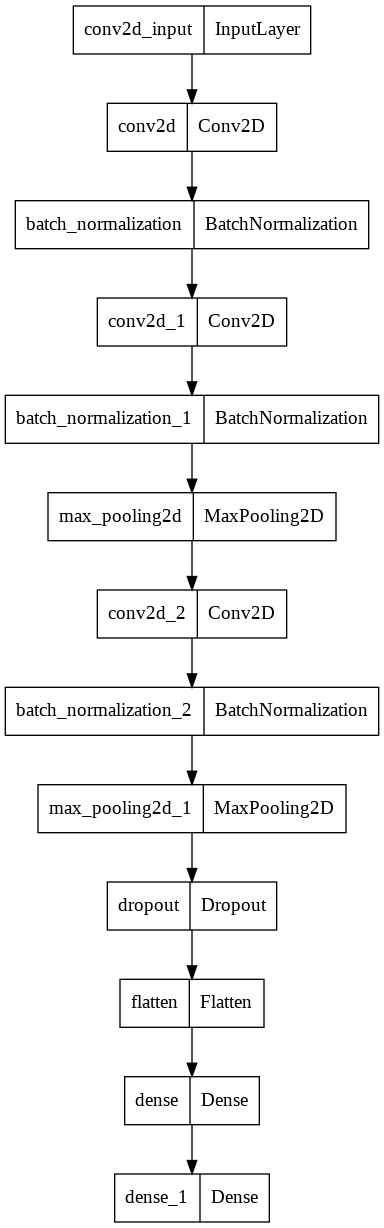

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
improved_model , to_file='improved_model.png', show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
def improved_model_train(improved_model,
                         train_images,
                         train_labels,
                         test_images,
                         test_labels):
  batch_size = 40
  validation_split = 0.25
  no_epochs = 50
  initial_learning_rate = 0.001

  #Early stopping the runs incase the validation loss does not improve
  earlystopper = EarlyStopping(monitor='val_loss',
                               mode='min', verbose=1,
                               patience=10)
  
  #Checkpointing the model to local storage on the basis of validation accuracy
  modelcheckpointer = ModelCheckpoint('best_model_improved.h5',
                                      monitor='val_accuracy',
                                      mode='max', verbose=1,
                                      save_best_only=True)
  
  #Reducing the learning rate when the validation accuracy does not increase
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=3, min_lr=0.00001)

  optimizer = tf.keras.optimizers.Adamax(learning_rate=initial_learning_rate)

  improved_model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[
          tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
      ],
  )

  # Data Augmentation using Image DataGenerator to add some variablity to the training set
  train_data_generator = ImageDataGenerator(rotation_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=False,
                                      fill_mode='constant')

  generated_train_data = train_data_generator.flow(train_images,
                                                   train_labels, 
                                                   batch_size=batch_size,
                                                   shuffle=True)

  test_data_generator = ImageDataGenerator()
  generated_test_data = test_data_generator.flow(test_images,
                                                 test_labels,
                                                 shuffle=True)

  # Training the improved model with augmented data
  history = improved_model.fit(generated_train_data,
                      steps_per_epoch= len(generated_train_data),
                      epochs=no_epochs,
                      validation_steps = len(generated_test_data),
                      verbose=1, validation_data=generated_test_data, callbacks=[modelcheckpointer, reduce_lr, earlystopper])
  #Evaluate the model
  saved_model = load_model('best_model_improved.h5')
  test_loss, test_accuracy = saved_model.evaluate_generator(generated_test_data, steps=len(test_images)//batch_size)
  print('Accuracy on test data : %.3f' % (test_accuracy))

  return history


In [ ]:
train_hist_improved = improved_model_train(improved_model, train_images, train_labels, test_images, test_labels)

Epoch 1/50
1249/1250 [============================>.] - ETA: 0s - loss: 4.1123 - accuracy: 0.0982
Epoch 1: val_accuracy improved from -inf to 0.16400, saving model to best_model_improved.h5
1250/1250 [==============================] - 37s 21ms/step - loss: 4.1119 - accuracy: 0.0983 - val_loss: 3.6745 - val_accuracy: 0.1640 - lr: 0.0010
Epoch 2/50
1249/1250 [============================>.] - ETA: 0s - loss: 3.4644 - accuracy: 0.1907
Epoch 2: val_accuracy improved from 0.16400 to 0.22880, saving model to best_model_improved.h5
1250/1250 [==============================] - 27s 21ms/step - loss: 3.4643 - accuracy: 0.1907 - val_loss: 3.2600 - val_accuracy: 0.2288 - lr: 0.0010
Epoch 3/50
1248/1250 [============================>.] - ETA: 0s - loss: 3.0468 - accuracy: 0.2602
Epoch 3: val_accuracy improved from 0.22880 to 0.28280, saving model to best_model_improved.h5
1250/1250 [==============================] - 26s 21ms/step - loss: 3.0463 - accuracy: 0.2604 - val_loss: 2.9212 - val_accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


Accuracy on test data : 0.498


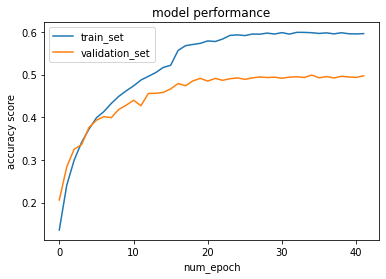

In [ ]:
create_accuracy_plot(train_hist_improved)

In [ ]:
end_time = time.time()
total_time = end_time - start_time
print(total_time)

1230.1372594833374
